In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai import *
from fastai.vision import *

import torch
from torch import nn
from dsin.ae.data_manager.data_loader import (
    SideinformationImageImageList, ImageSiTuple)
from dsin.ae import config
from dsin.ae.base_ae import BaseAutoEncoder
from dsin.ae.si_autoenc import SideInformationAutoEncoder

from dsin.ae.si_net import SiNetChannelIn
from dsin.ae.loss_man import LossManager
from dsin.ae.distortions import Distortions, DistTypes
from dsin.ae.kitti_normalizer import ChangeImageStatsToKitti, ChangeState
from dsin.ae import config


from dsin.train_utils.visibilty_utils.logger_cb_utils import setup_file_logger
from dsin.train_utils.visibilty_utils.pbar_cb_utils import (AverageMetric,
                                            ParameterMetricCallback,
                                            ProgressBarAttibuteVisualizer,
                                            ParameterRunningAverageMetricCallback,
                                            BitEntropy
                                           )
from dsin.train_utils.save_utils import FileNameGenerator

In [3]:
bpp = 0.1
H_target = 2* bpp
# config.autoencoder_loss_distortion_to_minimize=DistTypes.MS_SSMIM
config.K_MS_SSIM=500
config.beta

500

In [4]:
logger = setup_file_logger()

In [5]:
config.use_si_flag = SiNetChannelIn.WithSideInformation

#  LOAD BASE-AE

In [6]:
baseline_autoencoder = BaseAutoEncoder()
path = "../src/dsin/data"
pct= 1 #0.0005 #0.25

valid_image_list = SideinformationImageImageList.from_csv(
    path=path, csv_names=["KITTI_stereo_val.txt"],pct=pct/10)
train_image_list = SideinformationImageImageList.from_csv(
    path=path, csv_names=["KITTI_stereo_train.txt"],pct=pct)

image_lists = ItemLists(
    path=path, train=train_image_list, valid=valid_image_list)

batchsize = 1

tfms =  get_transforms(do_flip=True,
                       flip_vert=False,
                       max_rotate=False,
                       max_zoom=0,
                       max_lighting=False,
                       max_warp=False)

data = (image_lists
        .label_from_func(lambda x: x)
        .transform(None, size=(336, 336), resize_method=ResizeMethod.CROP, tfm_y=True)
        .databunch(bs=batchsize))

learn = Learner(data=data,
                     model=baseline_autoencoder,
                     opt_func=torch.optim.Adam,
                     loss_func=LossManager(baseline_autoencoder,SiNetChannelIn.NoSideInformation,use_feat_loss=False,target_bit_cost = H_target),
                     metrics=[AverageMetric(Distortions._calc_dist,"MS_SSIM")])
# learn.load('200815MAE-l2reg-baseline-1')
learn.load('2020-08-28try2-MAE-l2reg-baseline-bpp0p10-9')


Learner(data=ImageDataBunch;

Train: LabelList (1576 items)
x: SideinformationImageImageList
ImageSiTuple tensor([[[1.0000, 1.0000, 1.0000,  ..., 0.6465, 0.5606, 0.4442],
         [1.0000, 1.0000, 1.0000,  ..., 0.8471, 0.6217, 0.3216],
         [1.0000, 1.0000, 1.0000,  ..., 0.4640, 0.3560, 0.2957],
         ...,
         [0.1550, 0.1939, 0.1864,  ..., 0.1565, 0.1676, 0.1823],
         [0.1568, 0.1858, 0.1860,  ..., 0.1578, 0.1650, 0.1670],
         [0.1603, 0.1834, 0.1804,  ..., 0.1589, 0.1608, 0.1647]],

        [[1.0000, 1.0000, 1.0000,  ..., 0.6385, 0.4861, 0.3774],
         [1.0000, 1.0000, 1.0000,  ..., 0.7271, 0.5477, 0.2751],
         [1.0000, 1.0000, 1.0000,  ..., 0.6805, 0.4184, 0.2245],
         ...,
         [0.1924, 0.2211, 0.2177,  ..., 0.1893, 0.1998, 0.1952],
         [0.1898, 0.2229, 0.2052,  ..., 0.1811, 0.2007, 0.1996],
         [0.1986, 0.2157, 0.2199,  ..., 0.1912, 0.2059, 0.1923]],

        [[1.0000, 1.0000, 1.0000,  ..., 0.2690, 0.4330, 0.2803],
         [1.0000,

## Freeze Base AE before training first time with SI-AE

In [7]:
learn.freeze_to(-1)

# Create  SI-AE

In [8]:
si_autoencoder = SideInformationAutoEncoder(base_line_auto_enc = learn.model)


learn = Learner(data=data,
                     model=si_autoencoder,
                     opt_func=torch.optim.Adam,
                     loss_func=LossManager(si_autoencoder,SiNetChannelIn.WithSideInformation,use_feat_loss=False), #True
                     metrics=[AverageMetric(Distortions._calc_dist,"MS_SSIM")])

In [9]:
model_fname =FileNameGenerator.create_fname(f'MAE-l2reg-si-nofeat-bpp0p{bpp*100:.0f}')
lrs = [1e-4] *30  
model_fname,lrs

('2020-08-28MAE-l2reg-si-nofeat-bpp0p10',
 [0.0001,
  0.0001,
  0.0001,
  0.0001,
  0.0001,
  0.0001,
  0.0001,
  0.0001,
  0.0001,
  0.0001,
  0.0001,
  0.0001,
  0.0001,
  0.0001,
  0.0001,
  0.0001,
  0.0001,
  0.0001,
  0.0001,
  0.0001,
  0.0001,
  0.0001,
  0.0001,
  0.0001,
  0.0001,
  0.0001,
  0.0001,
  0.0001,
  0.0001,
  0.0001])

In [10]:
config.si_loss_weight_alpha = 0.7
learn.model.use_side_infomation = SiNetChannelIn.WithSideInformation
learn.loss_func.use_side_infomation = SiNetChannelIn.WithSideInformation

offset = 0
for i,lr in zip(range(offset,len(lrs)),lrs[offset:]):
    if i != 0:
        learn.load(f'{model_fname}-{i - 1}',with_opt=True)
    learn.fit(1, lr=lr,wd=0,callbacks=[ParameterRunningAverageMetricCallback(learn.loss_func),BitEntropy(loss_man=learn.loss_func,logger=logger,use_si=True)])
    learn.save(f'{model_fname}-{i}')
    !aws s3 cp ~/tDSIN/src/dsin/data/models/{model_fname}-{i}.pth  s3://dsin-us/models/
    !aws s3 cp ~/tDSIN/tutorials/out.log s3://dsin-us/models/{model_fname}-{i}.log


epoch,train_loss,valid_loss,MS_SSIM,time
0,226.162888,328.614929,1.017284,06:22


iter 0: bpp = 0.015 imp-mean-var(0.04 0.04) total loss229.8  l2reg_loss=13.6autoencoder_loss_value=19.4si_loss=111.6feat_loss_value=0.0
iter 500: bpp = 0.118 imp-mean-var(0.04 0.03) total loss161.6  l2reg_loss=13.6autoencoder_loss_value=29.6si_loss=40.8feat_loss_value=0.0
iter 1000: bpp = 0.130 imp-mean-var(0.03 0.03) total loss122.2  l2reg_loss=13.7autoencoder_loss_value=27.2si_loss=37.9feat_loss_value=0.0
iter 1500: bpp = 0.170 imp-mean-var(0.06 0.06) total loss222.3  l2reg_loss=13.7autoencoder_loss_value=28.7si_loss=30.3feat_loss_value=0.0
upload: ../src/dsin/data/models/2020-08-28MAE-l2reg-si-nofeat-bpp0p10-0.pth to s3://dsin-us/models/2020-08-28MAE-l2reg-si-nofeat-bpp0p10-0.pth
upload: ./out.log to s3://dsin-us/models/2020-08-28MAE-l2reg-si-nofeat-bpp0p10-0.log


epoch,train_loss,valid_loss,MS_SSIM,time
0,217.971725,189.254593,0.185786,06:21


iter 0: bpp = 0.029 imp-mean-var(0.10 0.09) total loss316.7  l2reg_loss=13.7autoencoder_loss_value=26.3si_loss=28.9feat_loss_value=0.0
iter 500: bpp = 0.180 imp-mean-var(0.06 0.06) total loss216.7  l2reg_loss=13.7autoencoder_loss_value=29.0si_loss=31.1feat_loss_value=0.0
iter 1000: bpp = 0.186 imp-mean-var(0.05 0.05) total loss204.3  l2reg_loss=13.8autoencoder_loss_value=30.9si_loss=30.4feat_loss_value=0.0
iter 1500: bpp = 0.225 imp-mean-var(0.08 0.07) total loss257.7  l2reg_loss=13.8autoencoder_loss_value=28.9si_loss=31.5feat_loss_value=0.0
upload: ../src/dsin/data/models/2020-08-28MAE-l2reg-si-nofeat-bpp0p10-1.pth to s3://dsin-us/models/2020-08-28MAE-l2reg-si-nofeat-bpp0p10-1.pth
upload: ./out.log to s3://dsin-us/models/2020-08-28MAE-l2reg-si-nofeat-bpp0p10-1.log


epoch,train_loss,valid_loss,MS_SSIM,time
0,282.545013,300.525452,0.650810,06:21


iter 0: bpp = 0.018 imp-mean-var(0.06 0.05) total loss210.0  l2reg_loss=13.8autoencoder_loss_value=34.9si_loss=30.2feat_loss_value=0.0
iter 500: bpp = 0.272 imp-mean-var(0.05 0.05) total loss184.9  l2reg_loss=13.9autoencoder_loss_value=23.9si_loss=27.1feat_loss_value=0.0
iter 1000: bpp = 0.203 imp-mean-var(0.09 0.08) total loss284.1  l2reg_loss=14.0autoencoder_loss_value=23.7si_loss=28.1feat_loss_value=0.0
iter 1500: bpp = 0.237 imp-mean-var(0.06 0.06) total loss227.0  l2reg_loss=14.0autoencoder_loss_value=27.3si_loss=24.9feat_loss_value=0.0
upload: ../src/dsin/data/models/2020-08-28MAE-l2reg-si-nofeat-bpp0p10-2.pth to s3://dsin-us/models/2020-08-28MAE-l2reg-si-nofeat-bpp0p10-2.pth
upload: ./out.log to s3://dsin-us/models/2020-08-28MAE-l2reg-si-nofeat-bpp0p10-2.log


epoch,train_loss,valid_loss,MS_SSIM,time


iter 0: bpp = 0.029 imp-mean-var(0.10 0.09) total loss310.7  l2reg_loss=14.0autoencoder_loss_value=26.0si_loss=27.9feat_loss_value=0.0
iter 500: bpp = 0.263 imp-mean-var(0.09 0.08) total loss287.5  l2reg_loss=14.1autoencoder_loss_value=24.9si_loss=24.2feat_loss_value=0.0


KeyboardInterrupt: 

In [12]:
learn.unfreeze()


In [14]:
model_fname =FileNameGenerator.create_fname(f'MAE-l2reg-si-nofeat-bpp0p{bpp*100:.0f}-unfrzd')
lrs = [1e-4] *30  
model_fname

'2020-08-28MAE-l2reg-si-nofeat-bpp0p10-unfrzd'

In [ ]:
offset = 0
for i,lr in zip(range(offset,len(lrs)),lrs[offset:]):
    if i != 0:
        learn.load(f'{model_fname}-{i - 1}',with_opt=True)
    learn.fit(1, lr=lr,wd=0,callbacks=[ParameterRunningAverageMetricCallback(learn.loss_func),BitEntropy(loss_man=learn.loss_func,logger=logger,use_si=True)])
    learn.save(f'{model_fname}-{i}')

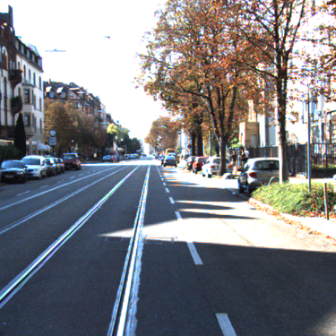

In [16]:
learn.data.train_ds[1][0].img

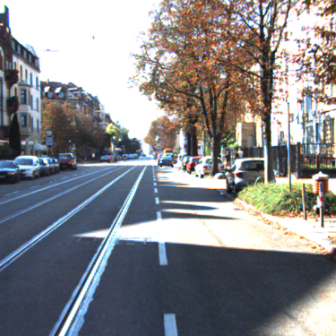

In [17]:
learn.data.train_ds[1][0].si_img

In [18]:
learn.loss_func.soft_bit_entropy

tensor(0.6967, device='cuda:0')

In [19]:
config.si_loss_weight_alpha

0.7

In [20]:
learn.loss_func.autoencoder_loss_value

tensor(19.0988, device='cuda:0')

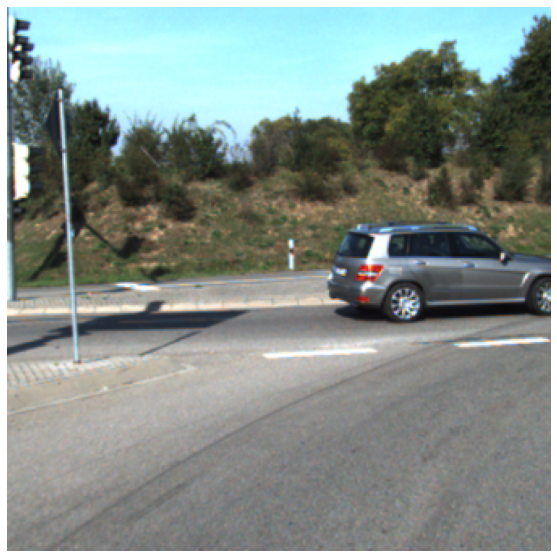

In [14]:
mt = learn.model.my_tuple[-2].squeeze_().detach()
mx, mn =torch.max(mt), torch.min(mt)
diff = mx-mn
show_image(Image(mt),figsize=(10,10))
# # print(mn)

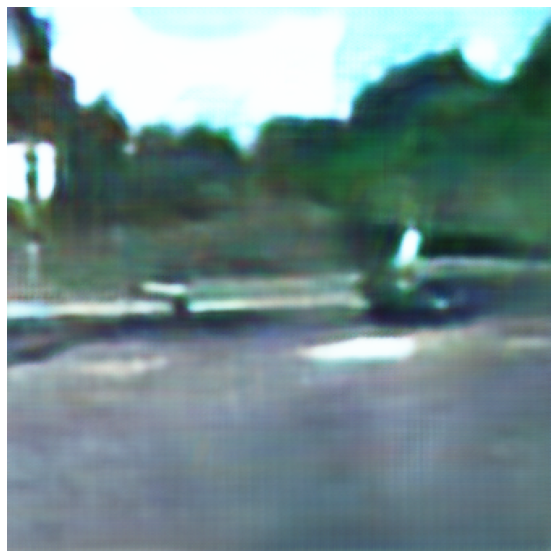

In [15]:

# # show_image(Image(learn.model.my_tuple[0][:,:50,:50]/255))
# # Image(learn.model.my_tuple[2].squeeze_().detach()/255.0)
mt = learn.model.my_tuple[2].squeeze_().detach()
mx, mn =torch.max(mt), torch.min(mt)
diff = mx-mn
show_image(Image(mt),figsize=(10,10))
# # print(mn)

# torch.min(learn.model.my_tuple[2].squeeze_().detach())

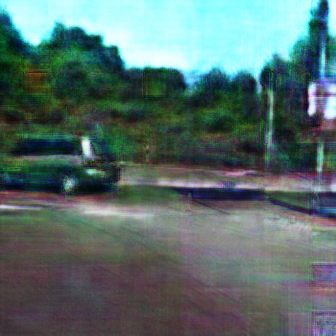

In [23]:
aaa = (mt - mn)/(diff)

flip_lr(Image(aaa.cpu()))

In [24]:
# learn.model.true_tuple_loss_false_just_out = False

# learn.show_results(figsize=(30,30))

In [25]:
learn.model.my_tuple[-2].data

tensor([[[0.6926, 0.6862, 0.7009,  ..., 0.5932, 0.5927, 0.5922],
         [0.6697, 0.6607, 0.6729,  ..., 0.5863, 0.6014, 0.6147],
         [0.6790, 0.6773, 0.6817,  ..., 0.5874, 0.6014, 0.6078],
         ...,
         [0.5083, 0.5906, 0.5688,  ..., 0.5542, 0.5248, 0.4262],
         [0.5434, 0.5250, 0.5933,  ..., 0.4763, 0.4866, 0.5252],
         [0.5553, 0.5348, 0.5981,  ..., 0.4667, 0.4735, 0.5288]],

        [[0.9603, 0.9607, 0.9711,  ..., 0.9167, 0.9176, 0.9254],
         [0.9553, 0.9612, 0.9730,  ..., 0.9220, 0.9189, 0.9259],
         [0.9707, 0.9723, 0.9730,  ..., 0.9183, 0.9254, 0.9294],
         ...,
         [0.5253, 0.5614, 0.6143,  ..., 0.5586, 0.4935, 0.4931],
         [0.5564, 0.5793, 0.5981,  ..., 0.5254, 0.5197, 0.4978],
         [0.5461, 0.5615, 0.5953,  ..., 0.5166, 0.5035, 0.4864]],

        [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.